<a href="https://colab.research.google.com/github/LockyWen/csc485/blob/master/USTravelAccident.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Data set 
!wget https://raw.githubusercontent.com/skyu0221/online-dropbox/master/ml/capstone1/project1/UK_RoadSafety_Accidents.csv

--2023-01-17 00:10:56--  https://raw.githubusercontent.com/skyu0221/online-dropbox/master/ml/capstone1/project1/UK_RoadSafety_Accidents.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18721065 (18M) [text/plain]
Saving to: ‘UK_RoadSafety_Accidents.csv’

UK_RoadSafety_Accid 100%[===================>]  17.85M   112MB/s    in 0.2s    

2023-01-17 00:10:59 (112 MB/s) - ‘UK_RoadSafety_Accidents.csv’ saved [18721065/18721065]



In [6]:
import numpy as np
import pandas as pd 
import scipy as sp
# Features pre-processing and principal component analysis (pca)
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# Train-test split
from sklearn.model_selection import train_test_split
# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

# Classifiers ensembling
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
import six
#from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import StackingClassifier
# Classifiers evaluation metrics
from sklearn.metrics import accuracy_score, roc_auc_score, auc, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef

# Random resampling
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Tuning hyperparameters
from sklearn.model_selection import RandomizedSearchCV

# Other
from time import time
from scipy.stats import ttest_ind

# Ploting
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from IPython.display import display
pd.options.display.float_format = '{:.3f}'.format

# Suppressing annoying harmless error
import warnings
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [16]:
import sys

python_print = print 
def print(*objects, sep=' ', end='\n', file=sys.stdout, color=(), fit_len=-1):
    line = "".join(map(str, objects))
    fit_len = max(fit_len - len(line), 0)
    for c in color:
      if len(objects) > 1:
        objects = (f"\033[{c}m{objects[0]}",) + objects[1:-1] + (
            f"{objects[-1]}{' ' * fit_len}\033[0m", )
      elif len(objects) == 1:
        objects = (f"\033[{c}m{objects[0]}{' ' * fit_len}\033[0m",)


# Preprocessing

In [24]:
df = pd.read_csv("UK_RoadSafety_Accidents.csv")

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136621 entries, 0 to 136620
Data columns (total 32 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   Accident_Index                               136621 non-null  object 
 1   Location_Easting_OSGR                        136614 non-null  float64
 2   Location_Northing_OSGR                       136614 non-null  float64
 3   Longitude                                    136614 non-null  float64
 4   Latitude                                     136614 non-null  float64
 5   Police_Force                                 136621 non-null  int64  
 6   Accident_Severity                            136621 non-null  int64  
 7   Number_of_Vehicles                           136621 non-null  int64  
 8   Number_of_Casualties                         136621 non-null  int64  
 9   Date                                         136621 non-nul

# Data-cleaning

In [18]:
# Find how many entry is missing in each feature 

print(df.isnull().sum())

In [19]:
df['Urban_or_Rural_Area'].unique() # Tell the data in this column

array([1, 2, 3])

In [26]:
# LSOA_of_Accident_Location stands for "Lower Super Output Area of Accident_Location (England & Wales Only)", therefore it's not very useful
df = df.drop(['LSOA_of_Accident_Location'], axis=1)
df = df.dropna(axis=0, how='any') # remove all null observations

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136575 entries, 0 to 136620
Data columns (total 31 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   Accident_Index                               136575 non-null  object 
 1   Location_Easting_OSGR                        136575 non-null  float64
 2   Location_Northing_OSGR                       136575 non-null  float64
 3   Longitude                                    136575 non-null  float64
 4   Latitude                                     136575 non-null  float64
 5   Police_Force                                 136575 non-null  int64  
 6   Accident_Severity                            136575 non-null  int64  
 7   Number_of_Vehicles                           136575 non-null  int64  
 8   Number_of_Casualties                         136575 non-null  int64  
 9   Date                                         136575 non-nul

# Data analysis

### Data aggregation


*   "Accident_Severity": Fatal(1), Serious(2), Slight(3)
--> "Serious_Accident": Serious/Fatal(1) vs Slight(1)



<ipython-input-29-5c600450769c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Serious_Accident'][df['Accident_Severity']==3] = 0


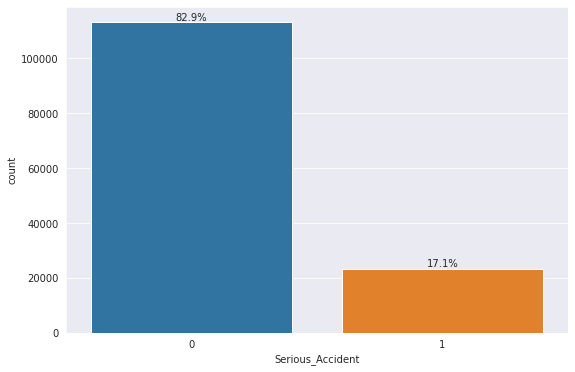

In [29]:
df['Serious_Accident'] = 1
df['Serious_Accident'][df['Accident_Severity']==3] = 0
print('Count of outcome variable', df['Serious_Accident'].value_counts())

plt.figure(figsize=(9, 6))
ax = sns.countplot(x=df.Serious_Accident)
for p in ax.patches:
    x = p.get_bbox().get_points()[:, 0]
    y = p.get_bbox().get_points()[1, 1]
    ax.annotate('{:.1f}%'.format(100. * y / df['Serious_Accident'].value_counts().sum()), (x.mean(), y),
                ha='center', va='bottom')
    
plt.show()

# Feature Engineering
## Latitude & Longitude 

In [32]:
slight = df[df['Serious_Accident']==0]
serious = df[df['Serious_Accident']==1]

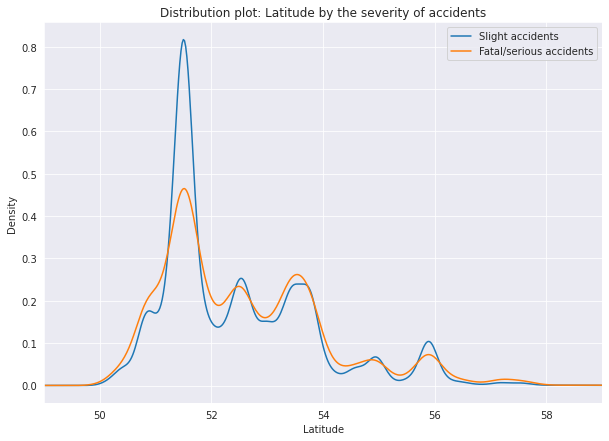

In [34]:
plt.figure(figsize=(10, 7))

# Latitude 
slight.Latitude.plot.density(label="Slight accidents") # Plot the density func based on Latitude
serious.Latitude.plot.density(label="Fatal/serious accidents")
plt.legend()
plt.title('Distribution plot: Latitude by the severity of accidents')
plt.xlim((49, 59))
plt.xlabel("Latitude")
plt.show()

### Since the 2 curves are not the same, we need to maintain the feature. This is the same as the longitude

#### Number of vehicles involved 

In [35]:
print("Statistics about number of vehicles involved in each accident", color=[93])
print(df["Number_of_Vehicles"].describe())
print()
print("Number of accidents for different number of vehicles", color=[92])
count = df.groupby("Number_of_Vehicles")["Accident_Index"].count().to_frame()
count["Percentage"] = count/len(df) * 100
print(count)

In [36]:
# To simplify the task, ignore accidents with more than 4 cars 
df = df.drop(df[df.Number_of_Vehicles > 4].index)

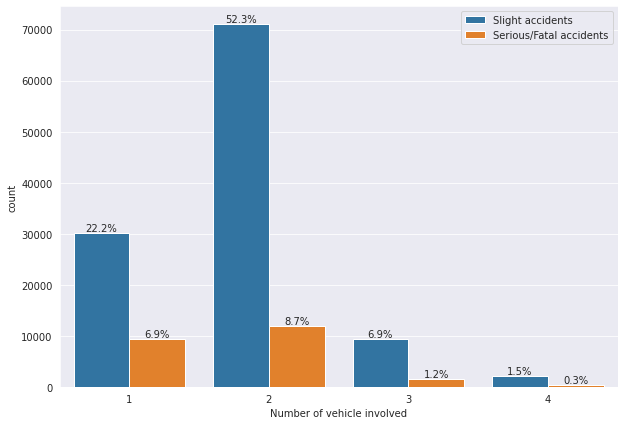

In [37]:
plt.figure(figsize=(10, 7))
ax = sns.countplot(x=df.Number_of_Vehicles, hue=df.Serious_Accident)
for p in ax.patches:
    x = p.get_bbox().get_points()[:, 0]
    y = p.get_bbox().get_points()[1, 1]
    ax.annotate('{:.1f}%'.format(100. * y / df['Serious_Accident'].value_counts().sum()), (x.mean(), y),
                ha='center', va='bottom')
plt.xlabel("Number of vehicle involved")
plt.legend(labels=['Slight accidents', 'Serious/Fatal accidents'])
plt.show()

In [38]:
df = df.drop(df[df.Number_of_Casualties > 4].index)

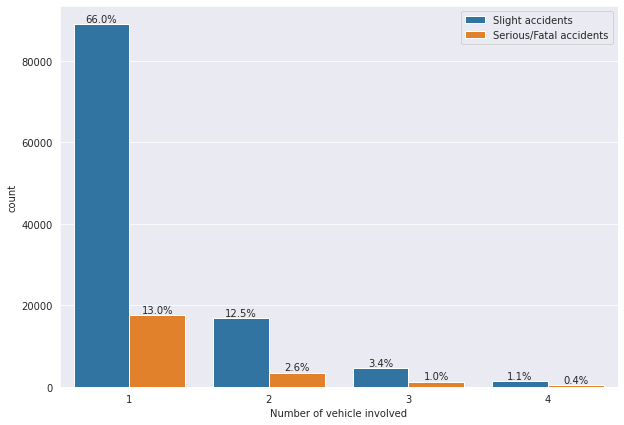

In [39]:
plt.figure(figsize=(10, 7))
ax = sns.countplot(x=df.Number_of_Casualties, hue=df.Serious_Accident)
for p in ax.patches:
    x = p.get_bbox().get_points()[:, 0]
    y = p.get_bbox().get_points()[1, 1]
    ax.annotate('{:.1f}%'.format(100. * y / df['Serious_Accident'].value_counts().sum()), (x.mean(), y),
                ha='center', va='bottom')
plt.xlabel("Number of vehicle involved")
plt.legend(labels=['Slight accidents', 'Serious/Fatal accidents'])
plt.show()

=========================== Categorical Variables =========================

In [41]:
# Chi sq test of independence 
# Null Hypothesis: diffeences between two data is caused by white noise 
# P-value < 0.05, reject the null hypothesis
def chi_sq_test(col1, col2):
  count_table = pd.crosstab(df[col1], df[col2])
  print(count_table)
  print(stats.chisquare(count_table, axis=None))

In [43]:
mapper = {1: "Sunday", 2: "Monday", 3: "Tuesday", 4: "Wednesday", 5: "Thursday", 6: "Friday", 7: "Saturday"}
df['Day_of_Week'] = [mapper[i] for i in df['Day_of_Week']]

In [44]:
df['Day_of_Week']

0          Tuesday
1          Tuesday
2          Tuesday
3          Tuesday
4          Tuesday
            ...   
136616      Friday
136617     Tuesday
136618    Thursday
136619    Saturday
136620      Sunday
Name: Day_of_Week, Length: 134633, dtype: object

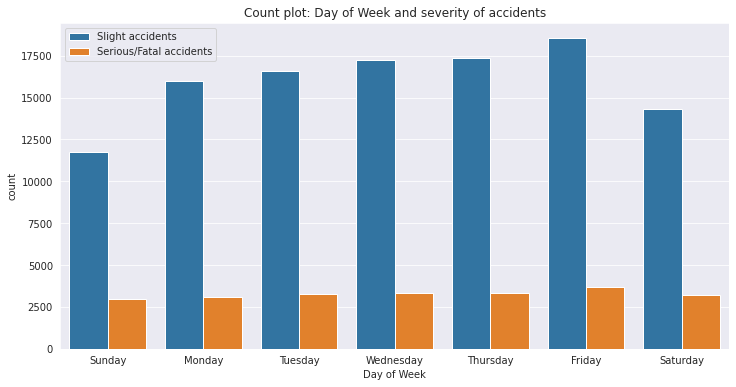

NameError: ignored

In [47]:
plt.figure(figsize=(12, 6))

sns.countplot(x=df['Day_of_Week'], hue="Serious_Accident", data=df, order=[mapper[i] for i in mapper])
plt.xlabel("Day of Week")
plt.title('Count plot: Day of Week and severity of accidents')
plt.legend(labels=['Slight accidents', 'Serious/Fatal accidents'])
plt.show()

print('Chi-squared test of independence between days of week and severity of accidents', color=[91])
print()
chi_sq_test('Serious_Accident', 'Day_of_Week')